In [1]:
import pinocchio as pin
import numpy as np
import time
import scipy
from example_robot_data import load

## visualise the robot
from pinocchio.visualize import MeshcatVisualizer

## visualise the polytope and the ellipsoid
import meshcat.geometry as g 

# import pycapacity 
import pycapacity as pycap

In [3]:
# use reachy's right arm with only 4 joints for now as they are the contribute 
# to its force capacity the most
urdf_path = '../reachy.urdf'
robot = pin.RobotWrapper.BuildFromURDF(urdf_path)
model, data = robot.model, robot.data
# lock the other joints
tolock = [
    'l_shoulder_pitch',
    'l_shoulder_roll',
    'l_elbow_yaw',
    'l_elbow_pitch',
    'l_wrist_roll',
    'l_wrist_pitch',
    'l_wrist_yaw',
    'l_hand_finger',
    'l_hand_finger_mimic',
    'r_wrist_roll',
    'r_wrist_pitch',
    'r_wrist_yaw',
    'r_hand_finger',
    'r_hand_finger_mimic',
    'neck_roll',
    'neck_pitch',
    'neck_yaw',
]

# Get the ID of all existing joints
jointsToLockIDs = []
for jn in tolock:
    if model.existJointName(jn):
        jointsToLockIDs.append(model.getJointId(jn))
robot.model = pin.buildReducedModel(model, jointsToLockIDs, np.zeros(21))
model, data = robot.model, robot.data

In [8]:
def jacobian(q, tip = robot.model.frames[-1].name):
    joint_id = model.getFrameId(tip)
    # joint_id = robot.model.getFrameId("r_wrist_ball_link")
    # joint_id =  model.getFrameId(robot.model.frames[-1].name)
    J = pin.computeFrameJacobian(robot.model,
                                       robot.data,
                                       q,
                                       joint_id,
                                       reference_frame=pin.LOCAL_WORLD_ALIGNED)[:3,:]
    u,s,v = np.linalg.svd(J)
    # print(J)
    return s

def dk(q, tip = robot.model.frames[-1].name):
    # joint_id =  robot.model.getFrameId(robot.model.frames[-1].name)
    joint_id = robot.model.getFrameId(tip)
    pin.framesForwardKinematics(robot.model, robot.data, q)
    return robot.data.oMf[robot.model.getFrameId(tip)].translation.copy()

In [5]:
data = robot.model.createData()

# get joint position ranges
q_max = robot.model.upperPositionLimit.T
q_min = robot.model.lowerPositionLimit.T
dq_max = np.ones(robot.nq)
dq_min = -dq_max
# get max velocity
t_max = np.ones(robot.nq)*4 # amps
t_min = -t_max

# Use robot configuration.
# q0 = np.random.uniform(q_min,q_max)
q = (q_min+q_max)/2

viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
# Start a new MeshCat server and client.
viz.initViewer(open=True)
# Load the robot in the viewer.
viz.loadViewerModel()
viz.display(q)
# small time window for loading the model 
# if meshcat does not visualise the robot properly, augment the time
# it can be removed in most cases
time.sleep(0.2) 

viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [6]:
from ipywidgets import interact, FloatSlider
kwargs = {'q[{}]'.format(i) : 
          FloatSlider(
              min = q_min[i], 
              max = q_max[i], 
              step = 0.01, 
              value = q[i],
              continuous_update=True) 
          for i,q_1 in enumerate(q)}
@interact(**kwargs)
def update(**kwargs):
    q = np.array([v  for v in kwargs.values()])
    viz.display(q)
    print(jacobian(q))

interactive(children=(FloatSlider(value=0.0, description='q[0]', max=1.5707963267948966, min=-1.57079632679489…

In [9]:
s_vals, pos = [], [] 
N = 40
for a in np.linspace(-np.pi/2,np.pi/2,N):
    for b in np.linspace(-np.pi,np.pi,N):
        q = np.array([a,b])
        s_vals.append(jacobian(q))
        pos.append(dk(q))
        
s_vals= np.array(s_vals)
pos= np.array(pos)
s_v = s_vals[:,0]*s_vals[:,1]
s_max = np.max(s_v)

ValueError: wrong argument size: expected 4, got 2
hint: The configuration vector is not of right size


In [10]:
s_vals, pos = [], [] 
N = 30
for a in np.linspace(q_min[0],q_max[0],N):
    for b in np.linspace(q_min[1],q_max[1],N):
        for d in np.linspace(q_min[2],q_max[2],N):
            for e in np.linspace(q_min[3],q_max[3],N):
                q = np.array([a,b,d,e])
                s_vals.append(jacobian(q, tip="r_wrist_ball_link"))
                pos.append(dk(q, tip="r_wrist_ball_link"))

s_vals = np.array(s_vals)
pos = np.array(pos)
s_v = s_vals[:,0]*s_vals[:,1]*s_vals[:,2]#*s_vals[:,3]
s_max = np.max(s_v)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18

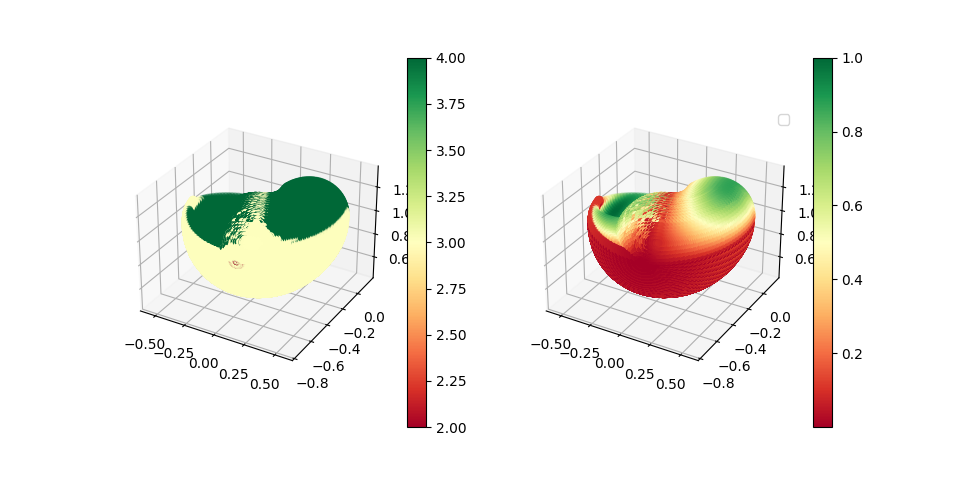

In [11]:
import matplotlib.pyplot as plt

s_lost_dofs = s_vals.copy()
s_lost_dofs[s_vals>=0.05] = 0
s_lost_dofs[s_vals< 0.05] = 1
s_lost_dofs = np.sum(s_lost_dofs,axis=1)

%matplotlib widget
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc = ax1.scatter(pos[:,0],pos[:,1],pos[:,2], 'o', c=robot.nq-s_lost_dofs, cmap = 'RdYlGn')
ax1.plot(0,-0.2,1,'bo',markersize=10)
plt.colorbar(sc)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc = ax2.scatter(pos[:,0],pos[:,1],pos[:,2], 'o', c=s_v/s_max, cmap = 'RdYlGn')
plt.colorbar(sc)
ax2.legend()


# Function to synchronize views between subplots
def on_move(event):
    if event.inaxes == ax1:
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
    fig.canvas.draw_idle()
    

# Connect the event handler
fig.canvas.mpl_connect('motion_notify_event', on_move)

In [ ]:
# Visualize the point cloud
p = np.array([[1.0,1.0,1.0],[1.0,1.0,0.0],[0.0,1.0,1.0],[1.0,0.0,1.0]]) 
# viz.viewer["point_cloud"].set_object(g.PointCloud(position=p.T, color=p.T,size=0.1))
viz.viewer["point_cloud"].set_object(g.PointCloud(position=pos.T, color=np.array([1-s_v/s_max, s_v/s_max, np.zeros_like(s_v)]),size=0.01))